# Search for duplicate users

#### Hardware
* Mid-2013 MacBook Air
* 1.3 GHz Core i5
* 4GB RAM
* Storage: USB 1.0 iomega external drive

#### Import Dependencies
* **Ujson:** UltraJSON is an ultra fast JSON encoder and decoder written in pure C with bindings for Python 2.5+ and 3. 
* **Gzip:** This module provides a simple interface to compress and decompress files just like the GNU programs gzip and gunzip
* **Collections defaultdict:** Returns a new dictionary-like object. Defaultdict is a subclass of the built-in dict class

#### Data: https://rffiles.s3.amazonaws.com/username_sample.jsonrows.gz 
Note: 12.5GB uncompressed

In [8]:
import ujson
import gzip
from collections import defaultdict

In [88]:
# performance lists
bottle_names = []
bottle_entries = []
bottle_export = []

#### Find Duplicate Names
* Created an index from duplicate names
* Used gzip to stream in data, unable to load into memory

In [10]:
#%%timeit - for use with jupyter notebook
def find_duplicate_names(file):
    #start = time.time()
    names = defaultdict(int)
    #stream file in one line at a time with gzip
    with gzip.open(file) as stream:
        for line in stream:
            obj = ujson.loads(line)
            names[obj['name']] += 1

    #count names and discard names that appear < 1
    names = { key:value for key, value in names.items() if value > 1 }
    names = dict((names, list()) for names in names)
    #bottle_names.append(time.time() - start)
    return(names)

#### Find Duplicate Tweets via Name Index
* Names are used as an index to scan potential duplicate tweets
* Full tweets are streamed and checked against names index
* The entire tweet is captured if there’s a match  

In [11]:
#%%timeit - for use with jupyter notebook
def find_duplicate_entries(file):
    #start_2 = time.time()
    #call find_duplicate_names - names to be matched with corresponding tweets
    names = find_duplicate_names(file)
    #stream file in one line at a time with gzip
    with gzip.open(file) as stream:
        for line in stream:
            obj = ujson.loads(line)
            if obj['name'] in names:
                names[obj['name']].append(obj)
            else:
                continue
    #bottle_entries.append(time.time() - start_2)
    return(names)

#### Merge & Export Function
* Merge happens at export in case there’s additional analysis to be done beforehand

In [12]:
#%%timeit - for use with jupyter notebook
def export_duplicates(file):
    #start_3 = time.time()
    #call find_duplicate_entries
    names = find_duplicate_entries(file)
    #write and merge
    with open("output_test_1.txt","w") as export:
        for key, tweet in names.items():
            ujson.dump({**tweet[0], **tweet[1]}, export)
    #bottle_export.append(time.time() - start_3)        

#### Call Function

In [92]:
# normal call function
#export_duplicates('username_sample_large.jsonrows.gz')

# Performance testing calls below
#........................................
# files = ['username_sample_1k.jsonrows.gz', 'username_sample_10k.jsonrows.gz', 'username_sample_100k.jsonrows.gz', 'username_sample_1m.jsonrows.gz', 'username_sample_10m.jsonrows.gz']
# file_length = [1, 10, 100, 1000, 10000]
# counters = []

# for file in files:
#     start = time.time()
#     export_duplicates(file)
#     counters.append(time.time() - start)


# bottleneck finder 
#........................................
for _ in range(50):
    export_duplicates('username_sample_100k.jsonrows.gz')
    

## Performance Benchmarking & Profiling

In [7]:
import time
import cProfile
import statistics
import matplotlib.pyplot as plt

### Time vs. Rows

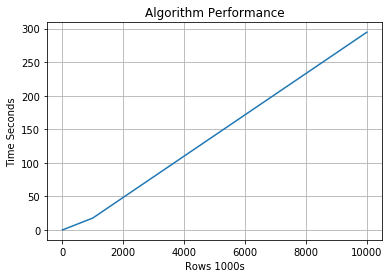

In [26]:
plt.plot(file_length, counters)
plt.ylabel('Time Seconds')
plt.xlabel('Rows 1000s')
plt.title('Algorithm Performance')
plt.grid(True)
plt.show()

### Finding the Bottlenecks 
* Data: username_sample_100k.jsonrows.gz
* Sample Size (per function): 50

#### Finding Names

Median Name Search: 0.928789496421814


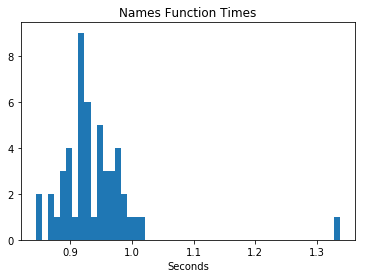

In [93]:
print("Median Name Search: " + str(statistics.median(bottle_names)))
plt.hist(bottle_names, bins=50)
plt.title('Names Function Times')
plt.xlabel('Seconds')
plt.show()

#### Finding Entries

Median Entries Search: 1.7753039598464966


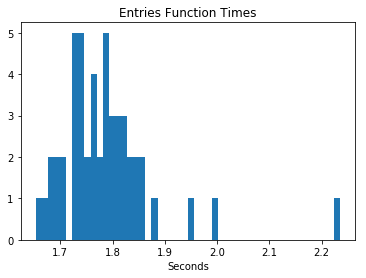

In [94]:
print("Median Entries Search: " + str(statistics.median(bottle_entries)))
plt.hist(bottle_entries, bins=50)
plt.title('Entries Function Times')
plt.xlabel('Seconds')
plt.show()

#### Export Duplicates

Median Export: 1.8108676671981812


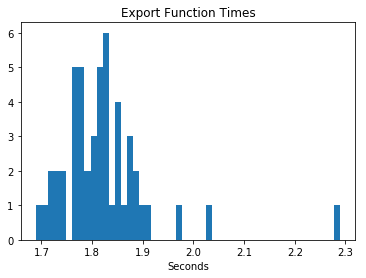

In [95]:
print("Median Export: " + str(statistics.median(bottle_export)))
plt.hist(bottle_export, bins=50)
plt.title('Export Function Times')
plt.xlabel('Seconds')
plt.show()

#### Combined Function Times

Median Names Search: 0.928789496421814
Median Entries Search: 1.7753039598464966
Median Export: 1.8108676671981812


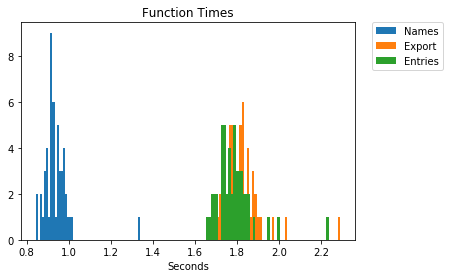

In [96]:
print("Median Names Search: " + str(statistics.median(bottle_names)))
print("Median Entries Search: " + str(statistics.median(bottle_entries)))
print("Median Export: " + str(statistics.median(bottle_export)))
plt.hist(bottle_names, bins=50, label="Names")
plt.hist(bottle_export, bins=50, label="Export")
plt.hist(bottle_entries, bins=50, label="Entries")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('Function Times')
plt.xlabel('Seconds')
plt.show()

### cProfiler
The profile below is a set of statistics that describes how often and for how long various parts of the program are executed

In [14]:
print("Export Duplicates")
cProfile.run("export_duplicates('username_sample_100k.jsonrows.gz')")

Export Duplicates
         1097246 function calls in 2.795 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.006    0.006    0.006    0.006 <ipython-input-10-a50014a206d0>:12(<dictcomp>)
       19    0.000    0.000    0.000    0.000 <ipython-input-10-a50014a206d0>:13(<genexpr>)
        1    0.244    0.244    1.790    1.790 <ipython-input-10-a50014a206d0>:2(find_duplicate_names)
        1    0.149    0.149    2.750    2.750 <ipython-input-11-c3dd5201376f>:2(find_duplicate_entries)
        1    0.001    0.001    2.793    2.793 <ipython-input-12-8b8e0d6fb254>:2(export_duplicates)
        1    0.001    0.001    2.795    2.795 <string>:1(<module>)
        1    0.000    0.000    0.000    0.000 _bootlocale.py:23(getpreferredencoding)
   200002    0.095    0.000    0.139    0.000 _compression.py:12(_check_not_closed)
        2    0.000    0.000    0.000    0.000 _compression.py:150(tell)
        2    0.000    0.000    